# Recommender Systems 2022/23

### Practice 3 - Collaborative Based recommenders


### Load the data you saw last time:

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/RecSys/libs

Mounted at /gdrive
/gdrive/My Drive/RecSys/libs


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
%matplotlib inline

Let's use the DataReader provided with the course repo

In [3]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

In [4]:
data = pd.read_csv(filepath_or_buffer="/gdrive/My Drive/RecSys/libs/data_train.csv",
                   sep=",")
data.columns = ["UserID", "ItemID", "Interaction"]

mapped_id, original_id = pd.factorize(data["UserID"].unique())
user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(data["ItemID"].unique())
item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

data["UserID"] = data["UserID"].map(user_original_ID_to_index)
data["ItemID"] = data["ItemID"].map(item_original_ID_to_index)

In [5]:
import scipy.sparse as sps

URM_all = sps.coo_matrix((data["Interaction"].values,
                          (data["UserID"].values, data["ItemID"].values)))

URM_all.tocsr()

<12638x22222 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [6]:

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2597 (20.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 2202 (17.4%) Users that have less than 1 test interactions


# Item-based Collaborative Filtering

#### We apply the cosine similarity again, but using the URM columns

In [7]:
item_id = 80
shrink = 10

numerator_vector = URM_train.T[item_id].dot(URM_train).toarray().ravel()
numerator_vector

array([12.,  4.,  4., ...,  0.,  0.,  0.])

In [8]:
item_norms = np.sqrt(np.array(URM_train.power(2).sum(axis=0))).ravel()
denominator_vector = item_norms[item_id] * item_norms + shrink + 1e-6

similarity_vector = numerator_vector/denominator_vector

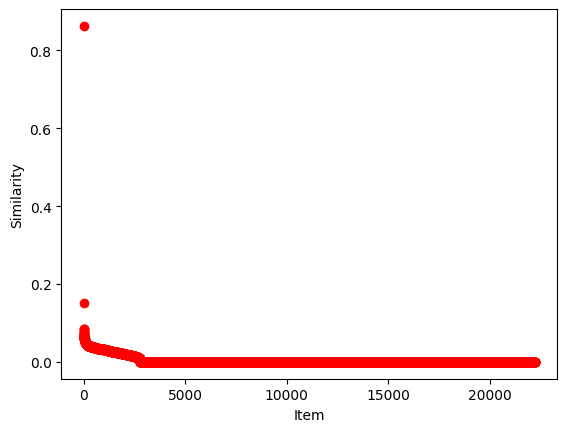

In [9]:
sorted_item_indices = np.argsort(-similarity_vector)

pyplot.plot(similarity_vector[sorted_item_indices], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Item')
pyplot.show()

### Let's compute the whole similarity and see the predictions for a certain item

In [10]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

similarity_object = Compute_Similarity_Python(URM_train, shrink=100,
                                              topK=50, normalize=True,
                                              similarity = "cosine")

W_sparse = similarity_object.compute_similarity()

Similarity column 22222 (100.0%), 1244.54 column/sec. Elapsed time 17.86 sec


In [11]:
user_id = 80

user_profile = URM_train[user_id]
scores = user_profile.dot(W_sparse).toarray().ravel()

ranking = scores.argsort()[::-1]

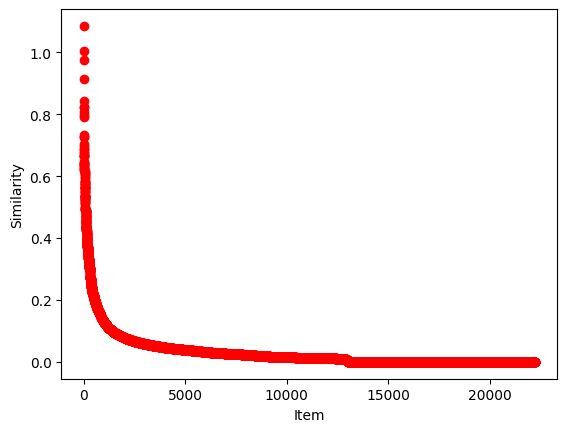

In [12]:
pyplot.plot(scores[ranking], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Item')
pyplot.show()

### Then compute the final recommendation list

In [13]:
ranking[0:10]

array([189, 284, 517,  44, 808, 881, 809, 228, 452, 289])

## Put all together in a class

In [14]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python
import numpy as np

class ItemKNNCFRecommender(object):

    def __init__(self, URM):
        self.URM = URM


    def fit(self, topK=50, shrink=100, normalize=True, similarity="cosine"):

        similarity_object = Compute_Similarity_Python(self.URM, shrink=shrink,
                                                  topK=topK, normalize=normalize,
                                                  similarity = similarity)

        self.W_sparse = similarity_object.compute_similarity()


    def recommend(self, user_id, at=10, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]

        return ranking[:at]


    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]

        scores[user_profile] = -np.inf

        return scores

## Test our CF recommender:

In [15]:
def precision(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)

    return precision_score

def recall(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]

    return recall_score

def AP(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))

    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

In [16]:
def evaluate_algorithm(URM_test, recommender_object, at=10):

    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0

    num_eval = 0


    for user_id in range(URM_test.shape[0]):

        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]

        if len(relevant_items)>0:

            recommended_items = recommender_object.recommend(user_id, at=at)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)

    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    MAP = cumulative_AP / num_eval

    print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, MAP))

In [17]:
recommender = ItemKNNCFRecommender(URM_train)
recommender.fit(shrink=0.0, topK=500)

Similarity column 22222 (100.0%), 806.64 column/sec. Elapsed time 27.55 sec


In [18]:
evaluate_algorithm(URM_test,recommender,10)

Recommender results are: Precision = 0.0553, Recall = 0.0864, MAP = 0.0457


## Remember to keep the URM in CSR format!

In [19]:
class TopPopRecommender(object):

    def fit(self, URM_train):

        self.URM_train = URM_train

        item_popularity = np.ediff1d(URM_train.tocsc().indptr)

        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popular_items = np.argsort(item_popularity)
        self.popular_items = np.flip(self.popular_items, axis = 0)


    def recommend(self, user_id, at=10, remove_seen=False):

        if remove_seen:
            seen_items = self.URM_train.indices[self.URM_train.indptr[user_id]:self.URM_train.indptr[user_id+1]]

            unseen_items_mask = np.in1d(self.popular_items, seen_items, assume_unique=True, invert = True)

            unseen_items = self.popular_items[unseen_items_mask]

            recommended_items = unseen_items[0:at]

        else:
            recommended_items = self.popular_items[0:at]


        return recommended_items


In [20]:
TopPopRecommender = TopPopRecommender()
TopPopRecommender.fit(URM_all)

In [37]:
class RandomRecommender(object):

    def fit(self, URM_train):

        self.n_items = URM_train.shape[1]


    def recommend(self, user_id, at=5):

        recommended_items = np.random.choice(self.n_items, at)

        return recommended_items

In [38]:
RandomRecommender = RandomRecommender()
RandomRecommender.fit(URM_all)

## Hyperarameter tuning

#### Once we have built our model we can play with its parameters
* Number of neighbors
* Shrinkage
* Similarity type

#### Optimize the recommendation qualtiy on the validation data, then use those hyperparameters to train the model in all the data you have (train + validation) and evaluate on the test data

#### Number of neighbors

In [21]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

x_tick = [10, 50, 100, 200, 500]
MAP_per_k = []

for topK in x_tick:

    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=topK)

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)

    MAP_per_k.append(result_df.loc[10]["MAP"])

KeyboardInterrupt: ignored

In [ ]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

#### On this dataset the number of neighbors has a great impact on MAP.

#### Different datasets will behave in different ways.

### Shrinkage

In [ ]:
x_tick = [0, 10, 50, 100, 200, 500]
MAP_per_shrinkage = []

for shrink in x_tick:

    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(shrink=shrink, topK=100)

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)

    MAP_per_shrinkage.append(result_df.loc[10]["MAP"])

In [ ]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

#### The shrinkage value (i.e. support) has no impact. Combine a parameter search with the two to ensure maximum recommendation quality

##**NOW WE TRY USING AN HIGHER NUMBER OF NEIGHBORS, BECAUSE INCREASING THE SHRINKAGE HAS NO REAL IMPACT**

In [ ]:
recommender2 = ItemKNNCFRecommender(URM_train)
recommender2.fit(shrink=0.0, topK=1000)

In [ ]:
evaluate_algorithm(URM_test,recommender2,10)

##**SUBMISSION**


## Submission to competition

This step serves as a similar step that you will perform when preparing a submission to the competition. Specially after you have chosen and trained your recommender.

For this step the best suggestion is to select the most-performing configuration obtained in the hyperparameter tuning step and to train the recommender using both the `train` and `validation` set. Remember that in the competition you *do not* have access to the test set.

We simulated the users to generate recommendations by randomly selecting 100 users from the original identifiers. Do consider that in the competition you are most likely to be provided with the list of users to generate recommendations.

Another consideration is that, due to easier and faster calculations, we replaced the user/item identifiers with new ones in the preprocessing step. For the competition, you are required to generate recommendations using the dataset's original identifiers. Due to this, this step also reverts back the newer identifiers with the ones originally found in the dataset.

Last, this step creates a function that writes the recommendations for each user in the same file in a tabular format following this format:
```csv
<user_id>,<item_id_1> <item_id_2> <item_id_3> <item_id_4> <item_id_5> <item_id_6> <item_id_7> <item_id_8> <item_id_9> <item_id_10>
```

Always verify the competitions' submission file model as it might vary from the one we presented here.

In [24]:
users_to_recommend_raw = pd.read_csv(filepath_or_buffer="/gdrive/My Drive/RecSys/libs/data_target_users_test.csv",
                   sep=",",
                  dtype={"user_id": np.int32}).to_numpy()
users_to_recommend = []
for elem in users_to_recommend_raw:
  users_to_recommend.append(elem[0])

len(users_to_recommend)

10882

In [25]:
ratings = pd.read_csv("/gdrive/My Drive/RecSys/libs/data_train2.csv",
                       sep=",",
                       names=["user_id", "item_id", "ratings"],
                       header=None,
                       dtype={"user_id": np.int64,
                               "item_id": np.int64,
                               "ratings": np.int64})
ratings.shape

(478730, 3)

In [26]:
def preprocess_data(ratings: pd.DataFrame):
    unique_users = ratings.user_id.unique()
    unique_items = ratings.item_id.unique()

    num_users, min_user_id, max_user_id = unique_users.size, unique_users.min(), unique_users.max()
    num_items, min_item_id, max_item_id = unique_items.size, unique_items.min(), unique_items.max()

    print(num_users, min_user_id, max_user_id)
    print(num_items, min_item_id, max_item_id)

    mapping_user_id = pd.DataFrame({"mapped_user_id": np.arange(num_users), "user_id": unique_users})
    mapping_item_id = pd.DataFrame({"mapped_item_id": np.arange(num_items), "item_id": unique_items})

    ratings = pd.merge(left=ratings,
                       right=mapping_user_id,
                       how="inner",
                       on="user_id")

    ratings = pd.merge(left=ratings,
                       right=mapping_item_id,
                       how="inner",
                       on="item_id")

    return ratings


In [27]:
ratings = preprocess_data(ratings)

12638 1 13024
22222 1 22347


In [ ]:
users_ids_and_mappings = ratings[ratings.user_id.isin(users_to_recommend)][["user_id", "mapped_user_id"]].drop_duplicates()
items_ids_and_mappings = ratings[["item_id", "mapped_item_id"]].drop_duplicates()
users_ids_and_mappings

In [29]:
def prepare_submission(ratings: pd.DataFrame, users_to_recommend: np.array, urm_train: sps.csr_matrix, recommender: object):
    users_ids_and_mappings = ratings[ratings.user_id.isin(users_to_recommend)][["user_id", "mapped_user_id"]].drop_duplicates()
    items_ids_and_mappings = ratings[["item_id", "mapped_item_id"]].drop_duplicates()

    mapping_to_item_id = dict(zip(ratings.mapped_item_id, ratings.item_id))


    recommendation_length = 10
    submission = []
    for idx, row in users_ids_and_mappings.iterrows():
        user_id = row.user_id
        mapped_user_id = row.mapped_user_id

        recommendations = recommender.recommend(mapped_user_id,recommendation_length)

        submission.append((user_id, [mapping_to_item_id[item_id] for item_id in recommendations]))


    return submission


In [30]:
submission = prepare_submission(ratings, users_to_recommend, URM_train, recommender)
len(submission)

10661

In [ ]:
submission

In [ ]:
missing_users = []
for elem in users_to_recommend:
  miss = True
  for sub in submission:
    if elem == sub[0]:
      miss = False
  if miss:
    missing_users.append(elem)
len(missing_users)
missing_users

In [60]:
top10 = []
top10 = TopPopRecommender.recommend(1,10)
top10


array([   0,    1,   44,  189,  284,  285,  517,  557,  808, 1266])

In [ ]:
for i in range(len(missing_users)):
  missing_users[i] = (missing_users[i], [top10[elem] for elem in range(10)])
missing_users


In [66]:
submission = submission + missing_users

In [67]:
len(submission)

10882

In [69]:
submission.sort()

In [ ]:
for i in range(len(submission)):
  submission[i][1].sort()
submission

In [72]:
def write_submission(submissions):
    with open("./submission.csv", "w") as f:
        for user_id, items in submissions:
            f.write(f"{user_id},{' '.join([str(item) for item in items])}\n")


In [73]:
write_submission(submission)